# 3 Components Data

In [1]:
import numpy as np
import time

from ml4pd import components
import flash_utils
from ml4pd.aspen_units import Flash
from ml4pd.streams import MaterialStream

input_molecules = flash_utils.get_mol_labels()
components.set_components(input_molecules['name'].to_list())

raw_data = flash_utils.get_benchmark_data(comp=3, date='220606')
data = flash_utils.add_name_columns(raw_data, input_molecules[['name', 'mol']])
data = flash_utils.rename_flowrate_columns(data)

## Benchmark Data Info

In [2]:
input_molecules.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
name,acetone,2-butanone,3-pentanone,3-hexanone,4-heptanone,4-octanone,5-nonanone,5-decanone,6-undecanone,6-dodecanone,6-tridecanone,7-tetradecanone,8-pentadecanone,water,carbon dioxide
mol,C3-ONE,C4-ONE,C5-ONE,C6-ONE,C7-ONE,C8-ONE,C9-ONE,C10-ONE,C11-ONE,C12-ONE,C13-ONE,C14-ONE,C15-ONE,H2O,CO2
smiles,CC(=O)C,CCC(=O)C,CCC(=O)CC,CCCC(=O)CC,CCCC(=O)CCC,CCCCC(=O)CCC,CCCCC(=O)CCCC,CCCCCC(=O)CCCC,CCCCCC(=O)CCCCC,CCCCCCC(=O)CCCCC,CCCCCCCC(=O)CCCCC,CCCCCCCC(=O)CCCCCC,CCCCCCCC(=O)CCCCCCC,O,C(=O)=O


In [3]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
flowrate_feed_A,12096.0,0.119533,0.066156,0.025641,0.065651,0.120719,0.162065,0.253731
flowrate_feed_B,12096.0,0.440234,0.033078,0.373134,0.418968,0.439641,0.467175,0.487179
flowrate_feed_C,12096.0,0.440234,0.033078,0.373134,0.418968,0.439641,0.467175,0.487179
flowrate_vapor_A,12096.0,0.070908,0.058747,0.000000,0.023837,0.057587,0.109484,0.253731
flowrate_vapor_B,12096.0,0.236345,0.145594,0.000000,0.115852,0.246874,0.363467,0.487179
flowrate_vapor_C,12096.0,0.192747,0.145102,0.000000,0.063064,0.172253,0.313764,0.487179
flowrate_liquid_A,12096.0,0.048625,0.052188,0.000000,0.009578,0.029135,0.072137,0.253731
flowrate_liquid_B,12096.0,0.203889,0.144616,0.000000,0.079647,0.190933,0.324360,0.487179
flowrate_liquid_C,12096.0,0.247486,0.144825,0.000000,0.133180,0.266041,0.373134,0.487179
feed_pressure,12096.0,15.050000,9.383694,0.100000,7.575000,15.050000,22.525000,30.000000


## Time Benchmark

In [4]:
times = []
for i in range(0, 10):
    start_time = time.time()
    feed_stream = MaterialStream(stream_type="feed")(
        vapor_fraction=data['feed_vapor_fraction'].to_list(),
        pressure=data['feed_pressure'].to_list(),
        molecules=flash_utils.get_name_columns(data).to_dict('list'),
        flowrates=flash_utils.get_flowrate_columns(data).to_dict('list'),
    )
    
    flash = Flash(
        pressure=data['feed_pressure'].to_list(),
        duty=data['flash_duty'].to_list()
    )

    vapo_stream, liqu_stream = flash(feed_stream)
    
    times.append(time.time() - start_time)

ordered_data = flash_utils.sort_targets_by_weight(data, feed_stream._mw_idx)

average = np.mean(times).round(2)
std = np.std(times).round(2)

print(f"{len(data)} data pts take {average} +/- {std} seconds to predict.")

c:\Users\Hvo\Miniconda3\envs\ml4pd\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Hvo\Miniconda3\envs\ml4pd\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator _SigmoidCalibration from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Hvo\Miniconda3\envs\ml4pd\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator CalibratedClassifierCV from version 1.0.2 when using version 1.1.1. This might lead to breaking cod

12096 data pts take 1.77 +/- 0.1 seconds to predict.


## Classifier Benchmark

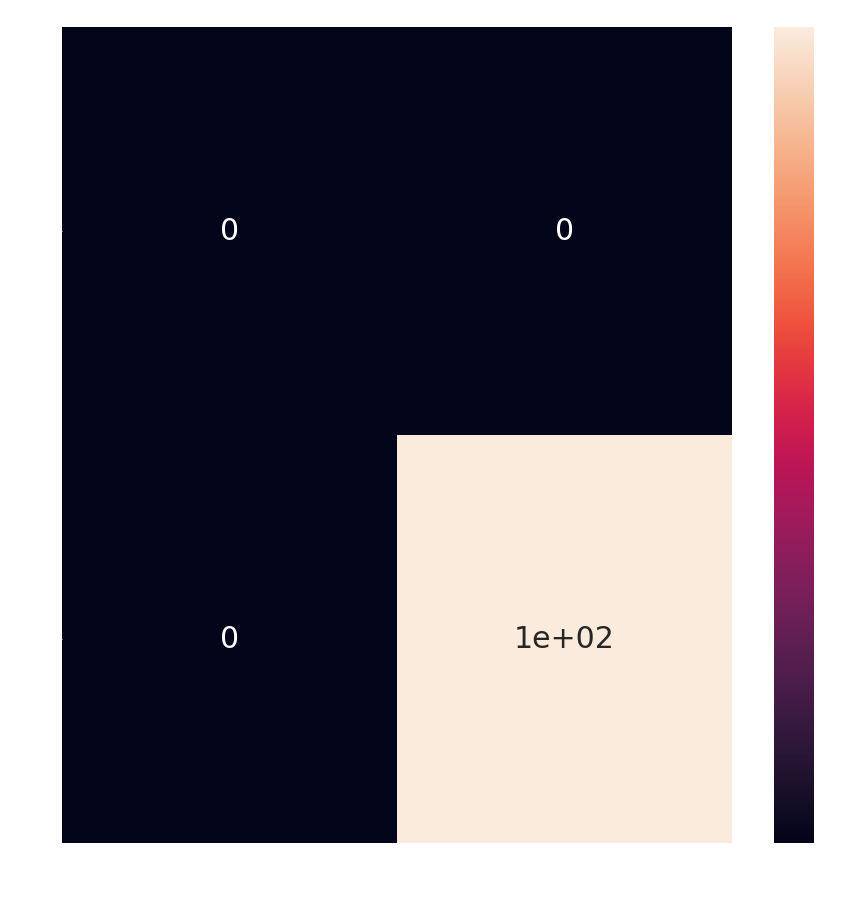

In [5]:
ok_idx = np.array(ordered_data[ordered_data['Status'] == 'OK'].index)
flash_utils.plot_confusion_matrix(ordered_data, flash.status)

## Flowrates Benchmark

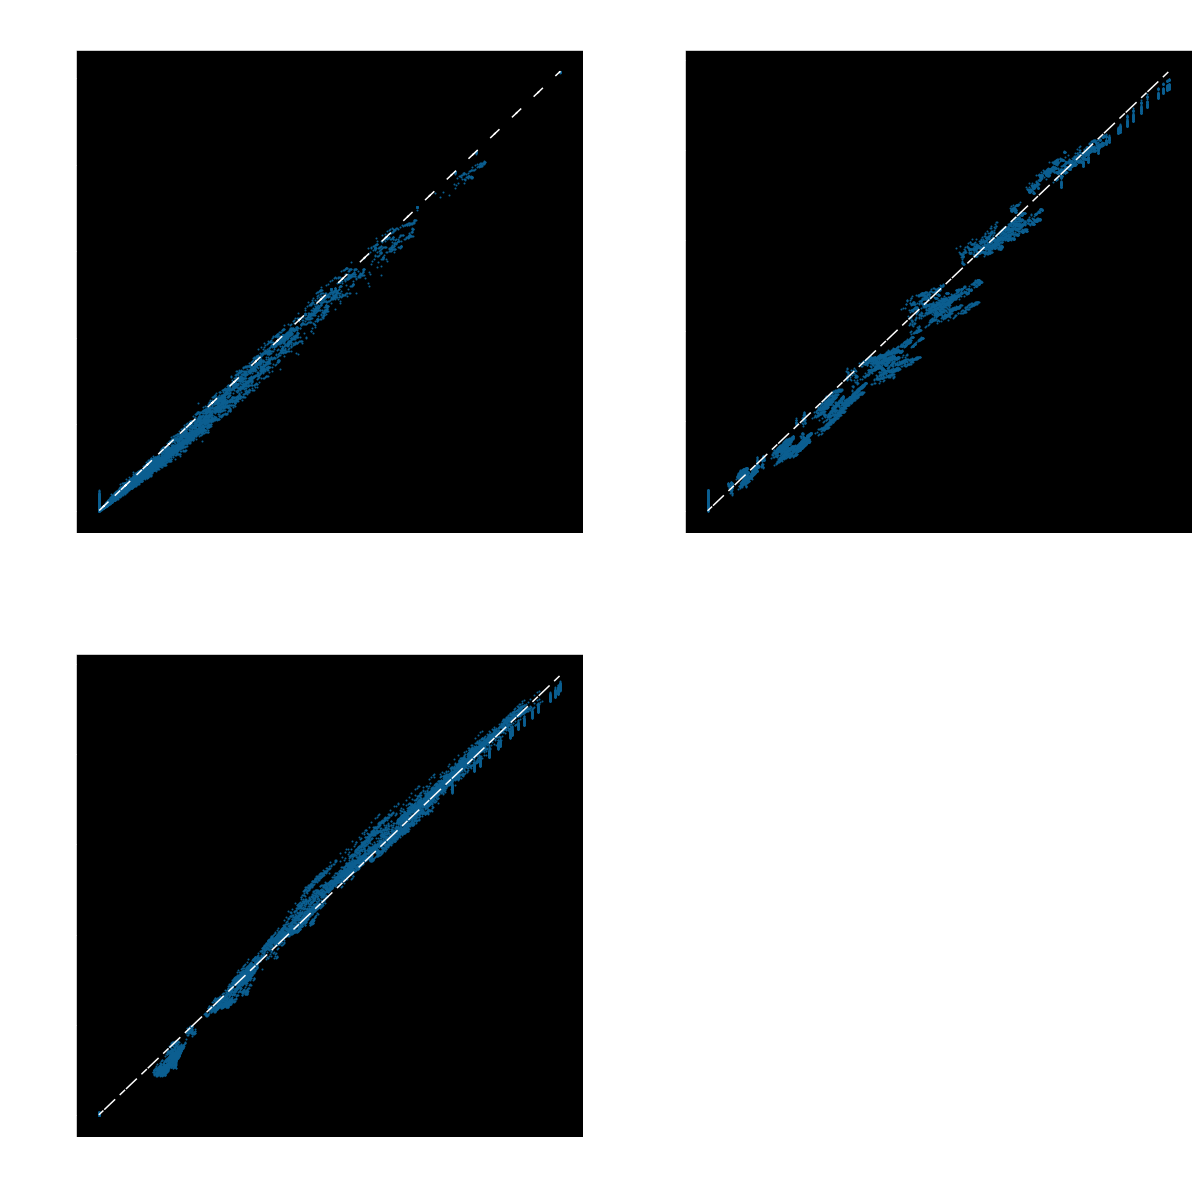

In [6]:
flash_utils.plot_flow(
    y_true=ordered_data.loc[ok_idx],
    y_pred=liqu_stream.flow.loc[ok_idx]
)

## Temperature Benchmark

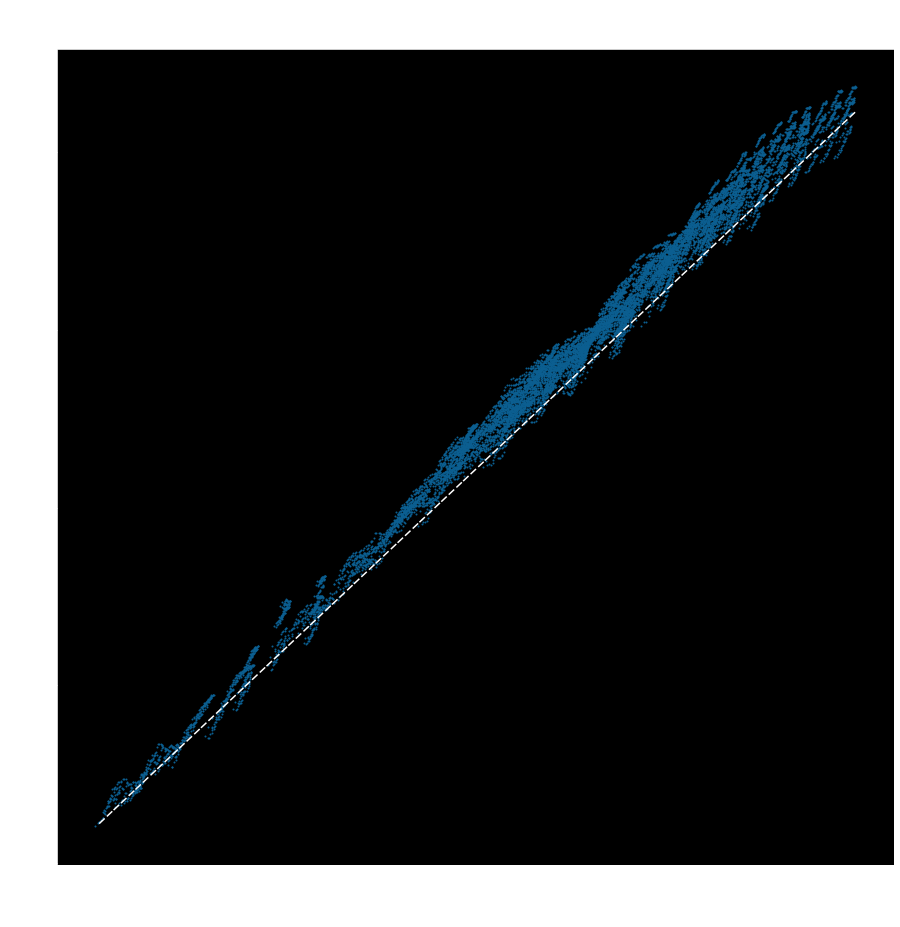

In [7]:
flash_utils.plot_temp(
    y_true=ordered_data,
    y_pred=liqu_stream.temperature,
    ok_idx=ok_idx
)

## Mean Absolute Errors

In [8]:
flash_utils.evaluate_flow(
    ordered_data.loc[ok_idx], 
    liqu_stream.flow.loc[ok_idx], 
    metric='mae'
)

,flowrate_liquid_A,flowrate_liquid_B,flowrate_liquid_C,mean
0,0.003151,0.01498,0.008023,0.008718


In [9]:
flash_utils.evaluate_temp(
    y_true=ordered_data,
    y_pred=liqu_stream.temperature,
    ok_idx=ok_idx
)

13.880691747496204